In [7]:
import numpy as np
import pandas as pd
import xlrd #读取excel的库
Y=[] #先声明一个空list
data=pd.read_csv(r"C:\Users\93631\Desktop\2020Himcm\mat\Y2.csv",header=None)
 #必须添加header=None，否则默认把第一行数据处理成列名导致缺失
Y=data.values.tolist()
Y=np.array(Y)
Y=np.delete(Y,0,axis=0)
data=pd.read_csv(r"C:\Users\93631\Desktop\2020Himcm\mat\R2.csv",header=None)
 #必须添加header=None，否则默认把第一行数据处理成列名导致缺失
R=data.values.tolist()
R=np.array(R)
R=np.delete(R,0,axis=0)
#先导入输入过评价的表格Y，R

In [8]:
#特征个数15
n_features = 15
def serialize(X, theta):
    return np.concatenate((X.ravel(), theta.ravel()))

def deserialize(params, n_job, n_user, n_features):
    return params[:n_job * n_features].reshape(n_job, n_features), \
           params[n_job * n_features:].reshape(n_user, n_features)
#代价函数
def cost(params, Y, R, n_features):
    n_job, n_user = Y.shape
    X, theta = deserialize(params, n_job, n_user, n_features)
    #注意这里只需要计算R=1的
    inner = np.multiply(X @ theta.T - Y, R)
    return np.power(inner, 2).sum() / 2
#梯度
def gradient(params, Y, R, n_features):
    n_job, n_user = Y.shape
    X, theta = deserialize(params, n_job, n_user, n_features)
    inner = np.multiply(X @ theta.T - Y, R)  # (231，326)
    X_grad = inner @ theta  #（231， 7）
    theta_grad = inner.T @ X  #（326，7）
    
    return serialize(X_grad, theta_grad)
#代价函数正规项
def regularized_cost(params, Y, R, n_features, lam=1):
    reg = np.power(params, 2).sum() * (lam / 2)
    return cost(params, Y, R, n_features) + reg
#梯度函数正规项
def regularized_gradient(params, Y, R, n_features, lam=1):
    grad = gradient(params, Y, R, n_features)
    reg = lam * params
    
    return grad + reg

In [9]:
#初始化x和theta为较小随机数，同时进行标准化
n_features = 15
n_job, n_user = Y.shape
lr = 10 #学习率
X = np.random.standard_normal((n_job, n_features))
theta = np.random.standard_normal((n_user, n_features))
#归一化
Y_norm = Y - Y.mean()
Y_norm.mean()

-3.066536026818548e-17

In [10]:
#模型训练
import scipy.optimize as opt
params = np.concatenate((np.ravel(X), np.ravel(theta)))
res = opt.minimize(fun=regularized_cost,
                   x0=params,
                   args=(Y_norm, R, n_features, lr),
                   method='TNC',
                   jac=regularized_gradient)
res

     fun: 8373.106202618976
     jac: array([-1.46141602e-06,  7.76769066e-07, -3.25323122e-06, ...,
       -2.30620980e-07,  8.99436912e-07,  8.78002760e-07])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 2052
     nit: 87
  status: 1
 success: True
       x: array([ 0.78653644, -0.38196758,  0.45851616, ...,  0.65812528,
       -0.38845072, -0.46576947])

In [11]:
#训练后的参数
X_trained, theta_trained = deserialize(res.x, n_job, n_user, n_features)
X_trained.shape, theta_trained.shape

((231, 15), (327, 15))

Predicting rating 6.3 for job number 60.
Predicting rating 5.8 for job number 207.
Predicting rating 5.6 for job number 68.
Predicting rating 5.5 for job number 92.
Predicting rating 5.5 for job number 148.
Predicting rating 5.5 for job number 54.
Predicting rating 5.4 for job number 161.
Predicting rating 5.2 for job number 199.
Predicting rating 5.1 for job number 0.
Predicting rating 5.1 for job number 151.


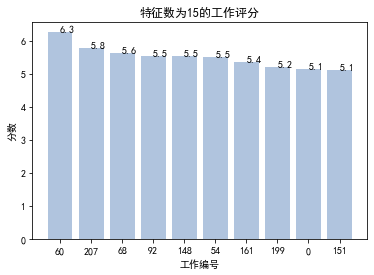

array([ 60, 207,  68,  92, 148,  54, 161, 199,   0, 151,  97, 196,  99,
       167, 203,  90,  18, 106,  81,  49,  53,  87, 220, 142, 209, 187,
       110,  64, 114, 130, 141, 185,  84, 181, 228,  67,  31, 173, 117,
        55, 224, 158,  28,  44, 166, 176,  47,  13, 123, 225, 212, 107,
         7, 164,   6, 180, 193,  10, 174,  19, 219, 214,  96, 112,   3,
       147,  11,  74, 165, 216, 135,  65, 134, 205, 226, 188, 179, 132,
         1, 101,  48,  63,  94, 189, 184, 113, 182, 138,  91,  89, 223,
       150,  32,  93,  73, 170, 149,   2, 229, 163, 169, 143,   5,  34,
       133, 201, 227,  69,  21, 152, 129, 137, 122, 140, 119, 217, 190,
       198,  72, 102,   4,  51, 146, 104,  45,  61, 144,  86, 168, 200,
        22,  52,  20,  57,  46,  15, 160, 121, 145,  35,  38,  76, 175,
         8,  85, 156, 213,  24, 218, 197, 211, 127, 222, 192, 230, 118,
       204, 124, 116,  37, 157, 210,  88,  33,  43,  58, 153, 159, 186,
        79, 155,  12, 109,  83,  14,  56, 105, 183, 208, 139,  5

In [13]:
#进行预测
import matplotlib.pyplot as plt
pred = X_trained @ theta_trained.T
final_preds = pred[:, -1] + Y.mean()
idx=np.argsort(final_preds)[::-1]
job_num=[]
score=[]
for i in range(10):
    print('Predicting rating %0.1f for job number %s.' %(final_preds[idx[i]],idx[i]))
    job_num=np.append(job_num,'%d' %idx[i])
    score=np.append(score,final_preds[idx[i]])
x_data=job_num
y_data=score
for i in range(0,10):
    plt.bar(x_data[i], y_data[i],color='lightsteelblue')
    plt.text(x_data[i], y_data[i],'%0.1f'%y_data[i])

# 正确显示中文和负号
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
plt.title("特征数为15的工作评分")
plt.xlabel("工作编号")
plt.ylabel("分数")
# 显示
plt.show()
idx